A standalone notebook to 
1. Pretrain $\Psi_{EQ}$
2. Pretrain $\Psi_{NEQ}$
3. Pretrain $\Phi$
4. Retrain the whole model with stress-stretch data

all in a single notebook for the synthetic data case. It needs training_data/gov_data.npy and NODE_fns.py to function. 
This notebook and nvisco_synthetic.py contain essentially the same stuff, except for figures. nvisco_synthetic.py was made to run this notebook on the cluster and instead of showing the figures it just saves them.

In [1]:
# Import and initialize
from jax.config import config
config.update('jax_platform_name', 'cpu') #Otherwise jax displays an annoying warning every time
config.update('jax_disable_jit', False)
config.update('jax_enable_x64', True)
#config.update('jax_debug_nans', True) #this checks outputs for nans everytime and reruns the function with non-optimized mode.


import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 16}
matplotlib.rc('font', **font)
from NODE_fns import NODE, NODE_nobias, sigma_split as sigma_NODE, sigma_split_vmap
from jax import grad, random, jit, vmap
from functools import partial
import jax.example_libraries.optimizers as optimizers
from jax.lax import cond, scan
from jax.experimental.ode import odeint
from diffrax import diffeqsolve, ODETerm, SaveAt, Heun as mysolver
import pickle
key = random.PRNGKey(0)
import jax

In [2]:
# Material parameters for the analytical model
mu_m = np.array([51.4, -18, 3.86])
alpha_m = np.array([1.8, -2, 7])
K_m = 10000
tau = 17.5
shear_mod = 1/2*(mu_m[0]*alpha_m[0] + mu_m[1]*alpha_m[1] + mu_m[2]*alpha_m[2])
eta_D = tau*shear_mod
eta_V = tau*K_m
mu = 77.77
K = 10000

# 1. Train $\Psi_{EQ}$ and $\Psi_{NEQ}$

## 1.1 $\Psi_{EQ}$

In [3]:
# Initialize parameters
def init_params(layers, key):
    Ws = []
    for i in range(len(layers) - 1):
        std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
        key, subkey = random.split(key)
        Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    return Ws

layers = [1, 5, 5, 1]
I1_params = init_params(layers, key)
I2_params = init_params(layers, key)
J1_params = init_params(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
Psi_eq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias)

def loss(params, lmb, sigma_gt):
    lm1 = lmb[:,0]
    lm2 = lmb[:,1]
    lm3 = lmb[:,2]
    sigma_pr = sigma_split_vmap(lm1, lm2, lm3, params)
    loss1 = np.average((sigma_pr[:,0,0]-sigma_gt[:,0,0])**2) 
    loss2 = np.average((sigma_pr[:,1,1]-sigma_gt[:,1,1])**2)
    loss = (loss1+loss2)/2
    return  loss

@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)

def train(loss, X, Y, opt_state, key, nIter = 10000, batch_size = 10):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        key, subkey = random.split(key)
        idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False)
        opt_state = step(loss, it, opt_state, X[idx_batch], Y[idx_batch])         
        if (it+1)% 10000 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss

# Generate training data
# Inputs
lm = np.linspace(0.9,1.2,20)
lm1, lm2 = np.array(np.meshgrid(lm, lm))
lm1 = lm1.reshape(-1)
lm2 = lm2.reshape(-1)
lm3 = 1/(lm1*lm2)
lmb = np.transpose(np.array([lm1, lm2, lm3]))

# Outputs (Neo Hookean for Psi_EQ)
sigma_gt = []
for i in range(lm1.shape[0]):
    b = np.array([[lm1[i]**2, 0, 0],
                  [0, lm2[i]**2, 0],
                  [0, 0, lm3[i]**2]])
    J = lm1[i]*lm2[i]*lm3[i]
    sigma_gt.append(mu/J*(b-np.eye(3)) + 2*K*(J-1)*np.eye(3))
sigma_gt = np.stack(sigma_gt)

# Train
opt_init, opt_update, get_params = optimizers.adam(1.e-5)
opt_state = opt_init(Psi_eq_params)
Psi_eq_params, train_loss, val_loss = train(loss, lmb, sigma_gt, opt_state, key, nIter = 50000, batch_size = 10)
# with open('saved/Psi_eq_params.npy', 'wb') as f:
#     pickle.dump(Psi_eq_params, f)

it 10000, train loss = 1.290316e+00
it 20000, train loss = 1.222895e+00
it 30000, train loss = 1.212647e+00
it 40000, train loss = 1.209345e+00
it 50000, train loss = 1.207923e+00


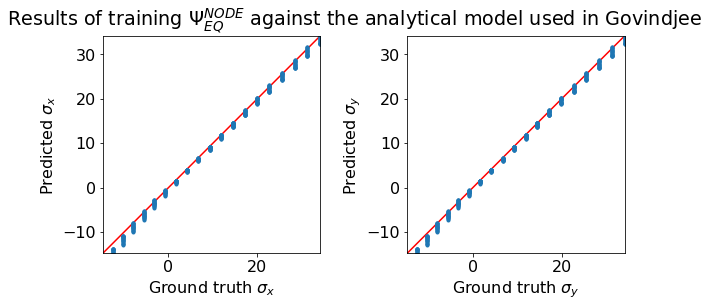

In [4]:
# Make predictions with the newly trained Neural ODEs
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, Psi_eq_params)
xmin,xmax = np.min(sigma_gt[:,0,0]), np.max(sigma_gt[:,0,0])
ymin,ymax = np.min(sigma_gt[:,1,1]), np.max(sigma_gt[:,1,1])
zmin,zmax = np.min(sigma_gt[:,2,2]), np.max(sigma_gt[:,2,2])

fig,ax = plt.subplots(1,2, figsize=[10,4])
ax[0].plot([xmin, xmax], [xmin, xmax], 'r-')
ax[0].plot(sigma_gt[:,0,0],sigma_pr[:,0,0],'.')
ax[1].plot([ymin, ymax], [ymin, ymax], 'r-')
ax[1].plot(sigma_gt[:,1,1],sigma_pr[:,1,1],'.')

fig.suptitle(r"Results of training $\Psi_{EQ}^{NODE}$ against the analytical model used in Govindjee")
ax[0].set(xlabel="Ground truth $\sigma_x$", ylabel='Predicted $\sigma_x$', aspect='equal', xlim=[xmin, xmax], ylim=[xmin, xmax])
ax[1].set(xlabel="Ground truth $\sigma_y$", ylabel='Predicted $\sigma_y$', aspect='equal', xlim=[ymin, ymax], ylim=[ymin, ymax])
# fig.savefig('figs/train_Psi_eq.jpg')
pass

## 1.2 $\Psi_{NEQ}$

In [5]:
# Initialize parameters
def init_params(layers, key):
    Ws = []
    for i in range(len(layers) - 1):
        std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
        key, subkey = random.split(key)
        Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    return Ws
layers = [1, 5, 5, 1]
I1_params = init_params(layers, key)
I2_params = init_params(layers, key)
J1_params = init_params(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
Psi_neq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias)

def loss(params, lmb, sigma_gt):
    lm1 = lmb[:,0]
    lm2 = lmb[:,1]
    lm3 = lmb[:,2]
    sigma_pr = sigma_split_vmap(lm1, lm2, lm3, params)
    loss1 = np.average((sigma_pr[:,0,0]-sigma_gt[:,0,0])**2) 
    loss2 = np.average((sigma_pr[:,1,1]-sigma_gt[:,1,1])**2)
    loss = (loss1+loss2)/2
    return  loss

@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)

def train(loss, X, Y, opt_state, key, nIter = 10000, batch_size = 10):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        key, subkey = random.split(key)
        idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False)
        opt_state = step(loss, it, opt_state, X[idx_batch], Y[idx_batch])         
        if (it+1)% 10000 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss

# Generate training data
# Inputs
lm = np.linspace(0.9,1.2,20)
lm1, lm2 = np.array(np.meshgrid(lm, lm))
lm1 = lm1.reshape(-1)
lm2 = lm2.reshape(-1)
lm3 = 1/(lm1*lm2)
lmb = np.transpose(np.array([lm1, lm2, lm3]))

# Outputs (Ogden type for Psi_NEQ)
def sigma_NEQ_gov(lm1, lm2, lm3):
    J = lm1*lm2*lm3

    lm1 = J**(-1/3)*lm1
    lm2 = J**(-1/3)*lm2
    lm3 = J**(-1/3)*lm3
    sigma11 = 0
    sigma22 = 0
    sigma33 = 0
    for i in range(3):
        sigma11+= mu_m[i]*lm1**(alpha_m[i]-1)
        sigma22+= mu_m[i]*lm2**(alpha_m[i]-1)
        sigma33+= mu_m[i]*lm3**(alpha_m[i]-1)
    sigma = np.array([[sigma11, 0, 0],
                      [0, sigma22, 0],
                      [0, 0, sigma33]])
    sigma = sigma/J

    p = 1/3*(sigma11 + sigma22 + sigma33)
    sigma = sigma - p

    sigma_vol = K_m/2*(J**2-1)*np.eye(3)
    sigma = sigma + sigma_vol
    return sigma
sigma_NEQ_vmap = vmap(sigma_NEQ_gov, in_axes=(0,0,0), out_axes=0)

sigma_gt = sigma_NEQ_vmap(lm1, lm2, lm3)

opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Psi_neq_params)
Psi_neq_params, train_loss, val_loss = train(loss, lmb, sigma_gt, opt_state, key, nIter = 100000, batch_size = 10)
# with open('saved/Psi_neq_params.npy', 'wb') as f:
#     pickle.dump(Psi_neq_params, f)

it 10000, train loss = 1.385685e-02
it 20000, train loss = 8.690150e-03
it 30000, train loss = 7.262387e-03
it 40000, train loss = 6.272890e-03
it 50000, train loss = 5.044337e-03
it 60000, train loss = 4.016302e-03
it 70000, train loss = 3.214708e-03
it 80000, train loss = 2.711890e-03
it 90000, train loss = 2.378881e-03
it 100000, train loss = 2.149925e-03


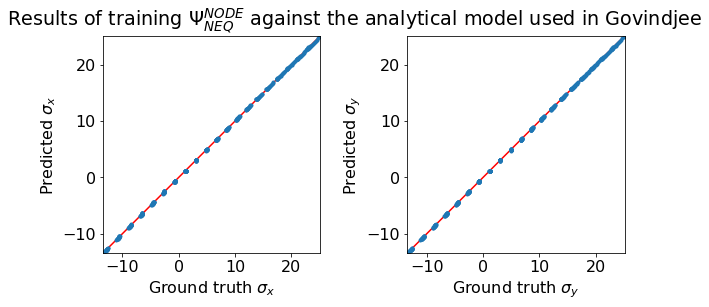

In [6]:
# Make predictions with the newly trained Neural ODEs
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, Psi_neq_params)
xmin,xmax = np.min(sigma_gt[:,0,0]), np.max(sigma_gt[:,0,0])
ymin,ymax = np.min(sigma_gt[:,1,1]), np.max(sigma_gt[:,1,1])
zmin,zmax = np.min(sigma_gt[:,2,2]), np.max(sigma_gt[:,2,2])

fig,ax = plt.subplots(1,2, figsize=[10,4])
ax[0].plot([xmin, xmax], [xmin, xmax], 'r-')
ax[0].plot(sigma_gt[:,0,0],sigma_pr[:,0,0],'.')
ax[1].plot([ymin, ymax], [ymin, ymax], 'r-')
ax[1].plot(sigma_gt[:,1,1],sigma_pr[:,1,1],'.')

fig.suptitle(r"Results of training $\Psi_{NEQ}^{NODE}$ against the analytical model used in Govindjee")
ax[0].set(xlabel="Ground truth $\sigma_x$", ylabel='Predicted $\sigma_x$', aspect='equal', xlim=[xmin, xmax], ylim=[xmin, xmax])
ax[1].set(xlabel="Ground truth $\sigma_y$", ylabel='Predicted $\sigma_y$', aspect='equal', xlim=[ymin, ymax], ylim=[ymin, ymax])
# fig.savefig('figs/train_Psi_neq.jpg')
pass

# 2. Train $\Phi^{NODE}$ with $\Phi^{Govindjee}$

In [7]:
# Generate training data
# Input data and normalization factors
taui = onp.mgrid[-200:200:10j, -200:200:10j, -200:200:10j]
taui = taui.reshape([3,-1]).transpose()
taui = -onp.sort(-taui)

tau1 = taui[:,0]
tau2 = taui[:,1]
tau3 = taui[:,2]
I12     = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
I12m3I2 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3

inp_std1 = onp.std(tau1)
inp_std2 = onp.std(tau1 + tau2)
inp_std3 = onp.std(tau1 + tau2 + tau3)
inp_std4 = onp.std(I12)
inp_std5 = onp.std(I12m3I2)
inp_stds = [inp_std1, inp_std2, inp_std3, inp_std4, inp_std5]

out_std1 = 1.0
out_std2 = 1.0
out_std3 = 1.0
out_std4 = 1/9/175000
out_std5 = 1/3/1360
out_stds = [out_std1, out_std2, out_std3, out_std4, out_std5]

# Output data
# Govindjee's dPhi/dtaui
def dPhi_gov(tau_i, etad = 1360, etav = 175000): 
    tau1, tau2, tau3 = tau_i
    trtau = tau1 + tau2 + tau3
    dphidtau1 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau2+tau3)
    dphidtau2 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau1+tau3)
    dphidtau3 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau1+tau2)
    return [dphidtau1, dphidtau2, dphidtau3]

dphidtaui = onp.zeros_like(taui)
for i in range(taui.shape[0]):
    dphidtaui[i] = dPhi_gov(taui[i], etad=eta_D, etav=eta_V)

In [8]:
# Initialize NN weights
# 2 different functions to initialize 2 different NN architectures
def init_params_positivebias(layers, key):
    Ws = []
    for i in range(len(layers) - 1):
        std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
        key, subkey = random.split(key)
        Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    b = np.zeros(layers[i + 1])
    return Ws, b
def init_params_nobias(layers, key):
    Ws = []
    for i in range(len(layers) - 1):
        std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
        key, subkey = random.split(key)
        Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    return Ws
layers = [1,2,3,1]
NODE1_params = init_params_nobias(layers, key)
NODE2_params = init_params_nobias(layers, key)
NODE3_params = init_params_positivebias(layers, key)
NODE4_params = init_params_positivebias(layers, key)
NODE5_params = init_params_positivebias(layers, key)
Phi_params = [NODE1_params, NODE2_params, NODE3_params, NODE4_params, NODE5_params]

# Neural ODE based dPhi/dtaui
def dPhi_NODE(taui, Phi_params):
    NODE1_params, NODE2_params, NODE3_params, NODE4_params, NODE5_params = Phi_params
    tau1 = taui[0]
    tau2 = taui[1]
    tau3 = taui[2]

    I1 = tau1
    I2 = tau1 + tau2
    I3 = tau1 + tau2 + tau3
    I4 = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
    I5 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3

    I1 = I1/inp_std1
    I2 = I2/inp_std2
    I3 = I3/inp_std3
    I4 = I4/inp_std4
    I5 = I5/inp_std5

    N1 = NODE_nobias(I1, NODE1_params)
    N2 = NODE_nobias(I2, NODE2_params)
    N3 = NODE(I3, NODE3_params)
    N4 = NODE(I4, NODE4_params) #I1^2
    N5 = NODE(I5, NODE5_params) #I1^2 - 3I2

    N1 = np.max(np.array([N1, 0]))
    N2 = np.max(np.array([N2, 0]))

    N1 = N1*out_std1
    N2 = N2*out_std2
    N3 = N3*out_std3
    N4 = N4*out_std4
    N5 = N5*out_std5

    Phi1 = N1 + N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau1 - tau2 - tau3) #dphi/dtau1
    Phi2 =      N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau2 - tau1 - tau3)
    Phi3 =           N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau3 - tau1 - tau2)

    return [Phi1, Phi2, Phi3]
dPhi_vmap = vmap(dPhi_NODE, in_axes=(0, None), out_axes = (0))

# Train
def loss(params, taui, dphidtaui_gt):
    tau1, tau2, tau3 = taui.transpose()
    dphidtaui_pr = dPhi_vmap([tau1, tau2, tau3], params)
    loss = np.average((dphidtaui_pr[0]-dphidtaui_gt[:,0])**2)
    loss+= np.average((dphidtaui_pr[1]-dphidtaui_gt[:,1])**2)
    loss+= np.average((dphidtaui_pr[2]-dphidtaui_gt[:,2])**2)
    return loss
@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)
def train(loss, X, Y, opt_state, key, nIter = 5000, batch_size = 100):
    global best_params
    train_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False)
        opt_state = step(loss, it, opt_state, X[idx_batch], Y[idx_batch])
        if it % 10000 == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss

opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Phi_params)
Phi_params, train_loss = train(loss, taui, dphidtaui, opt_state, key, nIter=200000)

# with open('saved/phi_params.npy', 'wb') as f:
#     pickle.dump(Phi_params, f)
# with open('saved/phi_norm_w.npy', 'wb') as f:
#     pickle.dump([inp_stds, out_stds], f)

it 0, train loss = 7.426098e+03
it 10000, train loss = 3.489257e+00
it 20000, train loss = 2.093395e-01
it 30000, train loss = 5.443931e-02
it 40000, train loss = 2.904087e-02
it 50000, train loss = 9.799070e-03
it 60000, train loss = 1.817775e-03
it 70000, train loss = 5.051457e-04
it 80000, train loss = 1.086502e-04
it 90000, train loss = 2.178192e-05
it 100000, train loss = 4.302881e-06
it 110000, train loss = 8.489958e-07
it 120000, train loss = 1.694360e-07
it 130000, train loss = 3.594759e-08
it 140000, train loss = 9.347598e-09
it 150000, train loss = 3.564368e-09
it 160000, train loss = 1.856795e-09
it 170000, train loss = 1.191659e-09
it 180000, train loss = 8.587147e-10
it 190000, train loss = 6.644192e-10
it 200000, train loss = 7.097098e-10


[Text(0.5, 0, 'Govindjee'), Text(0, 0.5, 'Prediction')]

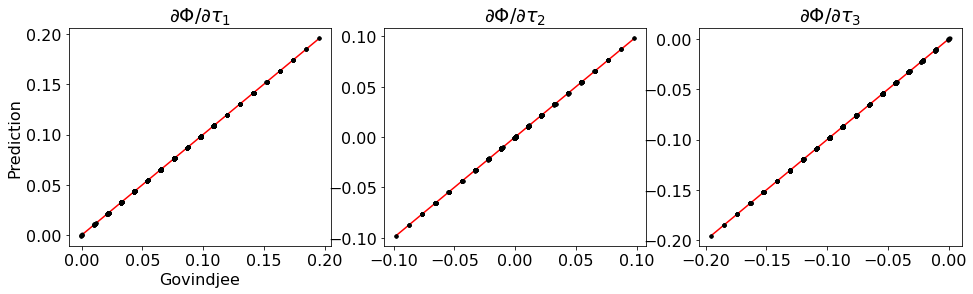

In [12]:
# Make predictions with the newly trained Neural ODEs
dphidtaui = dphidtaui.transpose()
dphidtaui_pr = dPhi_vmap([taui[:,0], taui[:,1], taui[:,2]], Phi_params)
dphidtaui_pr = onp.array(dphidtaui_pr)

fig,ax = plt.subplots(1,3, figsize=[16,4])
names = [1,2,3]
for i in range(3):
    mx = onp.max(dphidtaui[i])
    mn = onp.min(dphidtaui[i])
    ax[i].plot([mn, mx], [mn, mx], 'r')
    ax[i].plot(dphidtaui[i], dphidtaui_pr[i], 'k.')
    ax[i].set(title='$\\partial \\Phi / \\partial \\tau_{{ {s} }}$'.format(s = names[i]))
    
ax[0].set(xlabel='Govindjee', ylabel='Prediction')

# fig.savefig('figs/test_Phi.jpg')

# 3. Retrain the entire model with stress-stretch data

In [14]:
def tau_NEQ(lm1e, lm2e, lm3e):
    Je = lm1e*lm2e*lm3e
    
    b1 = Je**(-2/3)*lm1e**2
    b2 = Je**(-2/3)*lm2e**2
    b3 = Je**(-2/3)*lm3e**2

    devtau1 = 0
    devtau2 = 0
    devtau3 = 0
    for r in range(3):
        e = alpha_m[r]/2
        devtau1 = devtau1 + mu_m[r]*(2/3*b1**e - 1/3*(b2**e + b3**e)) #(B8)
        devtau2 = devtau2 + mu_m[r]*(2/3*b2**e - 1/3*(b1**e + b3**e))
        devtau3 = devtau3 + mu_m[r]*(2/3*b3**e - 1/3*(b1**e + b2**e))
    devtau = np.array([devtau1, devtau2, devtau3])

    tau_NEQI = 3*K_m/2*(Je**2-1) #(B8)
    tau_A = devtau + 1/3*tau_NEQI #(B8)
    return tau_A

def tau_NEQ_NODE(lm1, lm2, lm3, Psi_neq_params):
    J = lm1*lm2*lm3
    sigma_NEQ = sigma_NODE(lm1, lm2, lm3, Psi_neq_params)
    tau_NEQ = J*sigma_NEQ
    return tau_NEQ

def sigma(inputs, params, nnorgov):
    lm1, lm2, lm3, lm1e, lm2e, lm3e = inputs
    Psi_eq_params, Psi_neq_params, Phi_params = params

    if nnorgov: # use NODE
        sigma_EQ  = sigma_NODE(lm1, lm2, lm3, Psi_eq_params)
        sigma_NEQ = sigma_NODE(lm1e, lm2e, lm3e, Psi_neq_params)
    else: # use Govindjee
        J = lm1*lm2*lm3
        Je = lm1e*lm2e*lm3e
        
        b1 = Je**(-2/3)*lm1e**2
        b2 = Je**(-2/3)*lm2e**2
        b3 = Je**(-2/3)*lm3e**2

        devtau1 = 0
        devtau2 = 0
        devtau3 = 0
        for r in range(3):
            e = alpha_m[r]/2
            devtau1 = devtau1 + mu_m[r]*(2/3*b1**e - 1/3*(b2**e + b3**e)) #(B8)
            devtau2 = devtau2 + mu_m[r]*(2/3*b2**e - 1/3*(b1**e + b3**e))
            devtau3 = devtau3 + mu_m[r]*(2/3*b3**e - 1/3*(b1**e + b2**e))
        devtau = np.array([devtau1, devtau2, devtau3])

        tau_NEQI = 3*K_m/2*(Je**2-1) #(B8)
        tau_A = devtau + 1/3*tau_NEQI #(B8)
        tau_NEQ = np.array([[tau_A[0], 0, 0],
                            [0, tau_A[1], 0],
                            [0, 0, tau_A[2]]]) #Since stress and strain are coaxial in the isotropic case

        sigma_NEQ = 1/Je*tau_NEQ
        b = np.array([[lm1**2, 0, 0],
                    [0, lm2**2, 0],
                    [0, 0, lm3**2]])
        sigma_EQ = mu/J*(b-np.eye(3)) + 2*K*(J-1)*np.eye(3)
        
    sigma = sigma_NEQ + sigma_EQ
    return sigma
getsigma = vmap(sigma, in_axes=(0, None, None), out_axes=0)

dsigma33 = grad(lambda inputs, params, nnorgov: sigma(inputs,params,nnorgov)[2,2])

In [15]:
def yprime(y, t, lm1dot, lm2dot, tpeak, params, nnorgov):
    Psi_eq_params, Psi_neq_params, Phi_params = params
    lm1, lm2, lm3, lm1e, lm2e, lm3e = y

    true_fun  = lambda t: np.array([lm1dot, lm2dot])
    false_fun = lambda t: np.array([   0.0,    0.0], dtype='float64')
    lm1dot, lm2dot = cond(t<tpeak, true_fun, false_fun, t)

    if nnorgov: # use NODE 
        tau_A = tau_NEQ_NODE(lm1e, lm2e, lm3e, Psi_neq_params) 
        tau_A = np.array([tau_A[0,0], tau_A[1,1], tau_A[2,2]])
        dphidtaui = dPhi_NODE(tau_A, Phi_params)
    else: # use Govindjee
        tau_A = tau_NEQ(lm1e, lm2e, lm3e) 
        dphidtaui = dPhi_gov(tau_A)

    lm1edot = (lm1dot/lm1 - 0.5*dphidtaui[0])*lm1e
    lm2edot = (lm2dot/lm2 - 0.5*dphidtaui[1])*lm2e

    d = dsigma33([lm1,lm2,lm3,lm1e,lm2e,lm3e], params, nnorgov)
    A = -(d[0]*lm1dot + d[1]*lm2dot + d[3]*lm1edot + d[4]*lm2edot)/d[2]
    B = -d[5]/d[2]

    Apr = A/lm3
    Bpr = B/lm3

    lm3edot = (Apr - 0.5*dphidtaui[2])/(1-Bpr*lm3e)*lm3e
    lm3dot = A + B*lm3edot
    return lm1dot, lm2dot, lm3dot, lm1edot, lm2edot, lm3edot

In [16]:
@partial(jit, static_argnums=(1,))
def biaxial_visco(params, nnorgov, time, lm1, lm2):
    ipeak1 = np.argmax(np.abs(np.around(lm1, 3)-1.0)) #around(lm1, 3) evenly rounds lm1 to 3 decimals
    ipeak2 = np.argmax(np.abs(np.around(lm2, 3)-1.0))
    ipeak = np.max(np.array([ipeak1,ipeak2]))
    tpeak = time[ipeak]
    lm1peak = lm1[ipeak]
    lm2peak = lm2[ipeak]

    lm1dot = (lm1peak-1.0)/tpeak
    lm2dot = (lm2peak-1.0)/tpeak
    
    yprime2 = lambda t, y, args: np.array(yprime(y,t,lm1dot,lm2dot,tpeak,params,nnorgov))
    term = ODETerm(yprime2)
    solver = mysolver()
    y0 = np.array([1.0,1.0,1.0,1.0,1.0,1.0])
    saveat = SaveAt(ts=time)
    solution = diffeqsolve(term, solver, t0=0, t1=100, dt0=0.5, y0=y0, saveat=saveat)
    lm1, lm2, lm3, lm1e, lm2e, lm3e = solution.ys.transpose()

    sig = getsigma([lm1,lm2,lm3,lm1e,lm2e,lm3e], params, nnorgov)
    return sig, lm1, lm2, lm3, lm1e, lm2e, lm3e

In [17]:
#Load the training data and pre-trained parameters

# with open('saved/Psi_eq_params.npy', 'rb') as f:
#     Psi_eq_params = pickle.load(f)
# with open('saved/Psi_neq_params.npy', 'rb') as f:
#     Psi_neq_params = pickle.load(f)
# with open('saved/phi_params.npy', 'rb') as f:
#     Phi_params = pickle.load(f)
params = (Psi_eq_params, Psi_neq_params, Phi_params)
# with open('saved/phi_norm_w.npy', 'rb') as f:
#     [inp_stds, out_stds] = pickle.load(f)
# [inp_std1, inp_std2, inp_std3, inp_std4, inp_std5] = inp_stds
# [out_std1, out_std2, out_std3, out_std4, out_std5] = out_stds

with open('training_data/gov_data.npy','rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = np.load(f)

In [ ]:
def loss(params, nnorgov, time, lm1, lm2, sigma1, sigma2):
    sigma_pr,_,_,_,_,_,_ = biaxial_visco(params, nnorgov, time, lm1, lm2)
    loss = np.sum((sigma_pr[:,0,0]-sigma1[:])**2) + np.sum((sigma_pr[:,1,1]-sigma2[:])**2)
    return loss/lm1.shape[0]
loss_vmap = vmap(loss, in_axes=(None, None, 0, 0, 0, 0, 0), out_axes=0)

def batch_loss(params, nnorgov, time, lm1, lm2, sigma1, sigma2):
    loss = loss_vmap(params, nnorgov, time, lm1, lm2, sigma1, sigma2)
    loss = np.mean(loss)
    return loss

@partial(jit, static_argnums=(0,1,))
def step(loss_fn, nnorgov, i, opt_state, X1_batch, X2_batch, X3_batch, Y1_batch, Y2_batch):
    params = get_params(opt_state)
    g = grad(loss_fn, argnums=0)(params, nnorgov, X1_batch, X2_batch, X3_batch, Y1_batch, Y2_batch)
    return opt_update(i, g, opt_state)

def train(X1, X2, X3, Y1, Y2, opt_state, key, nIter = 1000, batch_size=10):
    train_loss = []
    val_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        i = random.choice(subkey, X1.shape[0], shape=(batch_size,), replace = False)
        i = tuple([i])
        opt_state = step(batch_loss, True, it, opt_state, X1[i], X2[i], X3[i], Y1[i], Y2[i])
        if it % 10 == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = batch_loss(params, True, X1[i], X2[i], X3[i], Y1[i], Y2[i])
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss 

opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(params)

params, train_loss, val_loss = train(time, lmb_x, lmb_y, sgm_x, sgm_y, opt_state, key, nIter = 500, batch_size=72)
with open('saved/params_retrained.npy', 'wb') as f:
    pickle.dump(params, f)

## Testing

In [ ]:
with open('saved/params_retrained.npy', 'rb') as f:
    params = pickle.load(f)

sigx_err = []
sigy_err = []
for j in range(time.shape[0]):
    t = time[j]
    lm1 = lmb_x[j]
    lm2 = lmb_y[j]
    sigx = sgm_x[j]
    sigy = sgm_y[j]
    sig,lm1,lm2,lm3,lm1e,lm2e,lm3e = biaxial_visco(params, True, t, lm1, lm2)
    sigx_err.append(np.abs(sig[:,0,0]-sgm_x[j]))
    sigy_err.append(np.abs(sig[:,0,0]-sgm_x[j]))

sigx_err = np.array(sigx_err)
sigy_err = np.array(sigy_err)
err = np.mean(np.array([sigx_err, sigy_err]), axis=0)
norm = np.max(err)
err_after = err/norm
err_after = err_after[::4]

In [13]:
with open('saved/phi_params.npy', 'rb') as f:
    Phi_params = pickle.load(f)
with open('saved/Psi_eq_params.npy', 'rb') as f:
    Psi_eq_params = pickle.load(f)
with open('saved/Psi_eq_params.npy', 'rb') as f:
    Psi_neq_params = pickle.load(f)
with open('training_data/gov_data.npy','rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = onp.load(f)
params = [Psi_eq_params, Psi_neq_params, Phi_params]

sigx_err = []
sigy_err = []
for j in range(time.shape[0]):
    t = time[j]
    lm1 = lmb_x[j]
    lm2 = lmb_y[j]
    sigx = sgm_x[j]
    sigy = sgm_y[j]
    sig,lm1,lm2,lm3,lm1e,lm2e,lm3e = biaxial_visco(params, True, t, lm1, lm2)
    sigx_err.append(np.abs(sig[:,0,0]-sgm_x[j]))
    sigy_err.append(np.abs(sig[:,0,0]-sgm_x[j]))

sigx_err = np.array(sigx_err)
sigy_err = np.array(sigy_err)
err = np.mean(np.array([sigx_err, sigy_err]), axis=0)
err_before = err/norm
err_before = err_before[::4]

Max error =  57.612241061801456


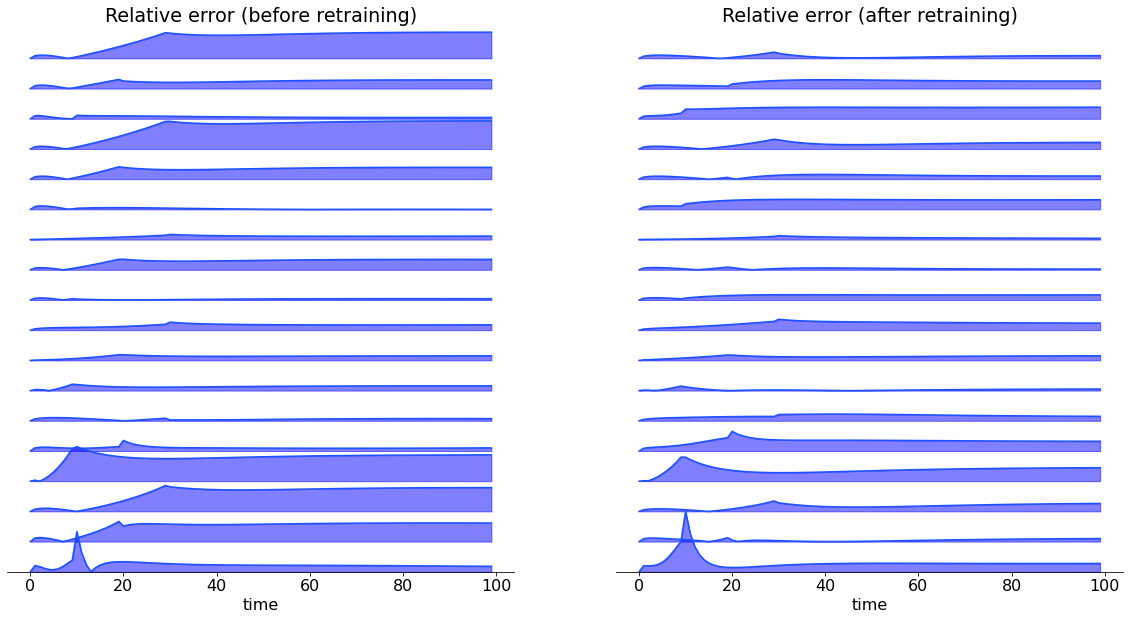

In [14]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].set(ylim=[0, err_before.shape[0]/2], yticks=[], xlabel='time', title='Relative error (before retraining)')
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['top'].set_visible(False)


ax[1].set(ylim=[0, err_before.shape[0]/2], yticks=[], xlabel='time', title='Relative error (after retraining)')
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['top'].set_visible(False)

for i in range(err_before.shape[0]):
    ax[0].plot(time[0], err_before[i]+i/2, '#1a53ff')
    zr = np.zeros(100) + i/2
    ax[0].fill_between(time[0], zr, err_before[i]+i/2, color='b', alpha=0.5)

    ax[1].plot(time[0], err_after[i]+i/2, '#1a53ff')
    zr = np.zeros(100) + i/2
    ax[1].fill_between(time[0], zr, err_after[i]+i/2, color='b', alpha=0.5)
print("Max error = ", norm)
pass

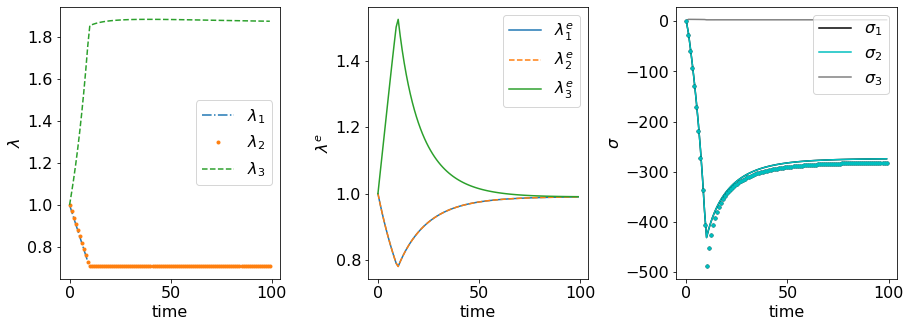

In [16]:
j = 0
i = 100
t = time[j,:i]
lm1 = lmb_x[j,:i]
lm2 = lmb_y[j,:i]
sigx = sgm_x[j,:i]
sigy = sgm_y[j,:i]
sig,lm1,lm2,lm3,lm1e,lm2e,lm3e = biaxial_visco(params, True, t, lm1, lm2)

fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.subplots_adjust(wspace=0.4)

ax[0].plot(t, lm1, '-.',label='$\lambda_1$')
ax[0].plot(t, lm2, '.',label='$\lambda_2$')
ax[0].plot(t, lm3, '--',label='$\lambda_3$')
ax[0].set(xlabel='time', ylabel='$\lambda$')
ax[0].legend() 

ax[1].plot(t, lm1e, label='$\lambda_1^e$')
ax[1].plot(t, lm2e, '--', label='$\lambda_2^e$')
ax[1].plot(t, lm3e, label='$\lambda_3^e$')
ax[1].set(xlabel='time', ylabel='$\lambda^e$')
ax[1].legend()

ax[2].plot(t, sig[:,0,0], 'k-',label='$\sigma_1$')
ax[2].plot(t, sig[:,1,1], 'c-',label='$\sigma_2$')
ax[2].plot(t, sig[:,2,2], 'gray',label='$\sigma_3$')
ax[2].plot(t, sigx, 'k.')
ax[2].plot(t, sigy, 'c.')
ax[2].set(xlabel='time', ylabel='$\sigma$')
ax[2].legend(loc='upper right') 
pass